# NYC Taxy Trips - Analysis

## Download files

To start, let us download de files and start the analysis. We did not keep than inside the git repository, since they have 2Gb, which we can download from its source.

Although there was no reason to keep the file's information in a separated json file for the current experiment, in a real world, parameters are used to be kept in a  separated file from code, which simplifies debug and deploy in a production enviroment.

In [1]:
from urllib.request import urlretrieve
import concurrent.futures 
import json
import os

if not(os.path.exists('files')):
        os.mkdir('files')


def download_files(params):    
    file = 'files/'+params[0]
    url = params[1]
    print(f'Download started: {file}')
#    urlretrieve(url, file)
    print(f'Download concluded: {file}')


with open('links.json') as f:
    links_json = json.load(f)
    links = [(x, y) for x,y in links_json.items()]
    files = ['files/'+x for x in links_json]
    
    
workers = len(links)    

with concurrent.futures.ThreadPoolExecutor(workers) as executor:
    executor.map(download_files, links)                                                                                                                                                                                                                                    

Download started: files/nyctaxi-trips-2009.json
Download concluded: files/nyctaxi-trips-2009.json
Download started: files/nyctaxi-trips-2010.json
Download concluded: files/nyctaxi-trips-2010.json
Download started: files/nyctaxi-trips-2011.json
Download concluded: files/nyctaxi-trips-2011.json
Download started: files/nyctaxi-trips-2012.json
Download concluded: files/nyctaxi-trips-2012.json
Download started: files/vendor-lookup.csv
Download started: files/payment-lookup.csvDownload concluded: files/vendor-lookup.csv
Download concluded: files/payment-lookup.csv



## Load files inside Dataframes

### NYC Taxi Trips

It is import to notice thar the json files are not corrected configured as a single json. Instead, they are multiple json information that were likely to be sent by an API or similar application. Hence, we will need to iterate throught each file and extract the collected data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dtype = {'vendor_id':'string', 'pickup_datetime':'datetime64[ns, UTC]', 'dropoff_datetime':'datetime64[ns, UTC]', 'passenger_count':'int8', 'trip_distance':'float32', 
         'pickup_longitude':'float32', 'pickup_latitude':'float32', 'rate_code':'float32', 'store_and_fwd_flag':'float32', 'dropoff_longitude':'float32',
         'dropoff_latitude':'float32', 'payment_type':'string', 'fare_amount':'float32', 'surcharge':'float32','tip_amount':'float32', 'tolls_amount':'float32', 'total_amount':'float32'}

In [4]:
def return_nyc_taxi_json_as_dataframe(nyc_taxi_list):
    length = 0
    nytax_trips_dict = dict()
    
    for col in dtype:
        nytax_trips_dict[col] = list()
    
    for nyc_taxi_file in nyc_taxi_list:
        print(f"Loading file: {nyc_taxi_file}")
        
        with open(nyc_taxi_file) as f:
            file_list = f.readlines()
        
    
        length+= len(file_list)
        for line in file_list:
            line_dict = json.loads(line) 
            for name, value in line_dict.items():
                nytax_trips_dict[name].append(value)
        print(f"File loaded: {nyc_taxi_file}")
    
    print(f"Number of expected rows: {length}")
    return pd.DataFrame.from_dict(nytax_trips_dict).astype(dtype)

In [5]:
json_files = files[:4]
nyc_taxi_trips_df = return_nyc_taxi_json_as_dataframe(json_files)
print(f"Number of loaded rows: {nyc_taxi_trips_df.shape[0]}")

Loading file: files/nyctaxi-trips-2009.json
File loaded: files/nyctaxi-trips-2009.json
Loading file: files/nyctaxi-trips-2010.json
File loaded: files/nyctaxi-trips-2010.json
Loading file: files/nyctaxi-trips-2011.json
File loaded: files/nyctaxi-trips-2011.json
Loading file: files/nyctaxi-trips-2012.json
File loaded: files/nyctaxi-trips-2012.json
Number of expected rows: 4000000
Number of loaded rows: 4000000


In [6]:
nyc_taxi_trips_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount
0,CMT,2009-04-21 18:51:11.767205+00:00,2009-04-21 18:57:09.433767+00:00,2,0.80,-74.004112,40.742950,NaN,NaN,-73.994713,40.747952,Cash,5.4,0.0,0.0,0.0,5.4
1,CMT,2009-01-13 07:40:07.639754+00:00,2009-01-13 07:50:36.386011+00:00,1,5.40,-73.996506,40.747784,NaN,NaN,-73.940453,40.792385,Cash,15.4,0.0,0.0,0.0,15.4
2,VTS,2009-01-06 19:30:44.142187+00:00,2009-01-06 19:43:09.908429+00:00,5,1.67,-73.951340,40.752071,NaN,NaN,-73.944534,40.768108,CASH,6.1,1.0,0.0,0.0,7.1
3,VTS,2009-09-24 08:28:09.004451+00:00,2009-09-24 08:41:56.739991+00:00,1,4.13,-74.001114,40.729130,NaN,NaN,-73.958122,40.721813,CASH,12.9,0.5,0.0,0.0,13.4
4,VTS,2009-10-29 05:50:39.214629+00:00,2009-10-29 05:57:22.880174+00:00,1,2.03,-73.976601,40.756874,NaN,NaN,-73.979759,40.776073,CASH,7.7,0.5,0.0,0.0,8.2


### Payment Lookup

In [7]:
payment_df = pd.read_csv(files[4])
payment_df.head()

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


### Vendor Lookup

The vendor-lokup.csv is a file with inconsistent data that has no use to the current code. For this reason, we will ignore the useless information and load only what matters inside a dataframe  

In [8]:
vendor_df = pd.read_csv(files[5], header=1,nrows=17)
vendor_df.head()

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit
3,CRE,Credit
4,No,No Charge


## 1. What is the average distance traveled by trips with a maximum of 2 passengers:

First let us collect only the information need to solve that problem

In [9]:
trip_distance_max_2_df = nyc_taxi_trips_df[nyc_taxi_trips_df.passenger_count <= 2].trip_distance
trip_distance_max_2_df.describe()

count    3.319652e+06
mean     2.662526e+00
std      3.112605e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.680000e+00
75%      3.000000e+00
max      4.970000e+01
Name: trip_distance, dtype: float64

We can see that the min value is 0. This situation might reflects someone who requests a trip but cancels it and the fare is charged. To find our answer this kind of trip is not valuable (since it will change the average distance and it will not represents the reality of trips that actually were made)

In [10]:
trip_distance_max_2_df.groupby(trip_distance_max_2_df!=0).count()

trip_distance
False      31480
True     3288172
Name: trip_distance, dtype: int64

trip_distance
Cancelled      31480
Concluded    3288172
Name: trip_distance, dtype: int64


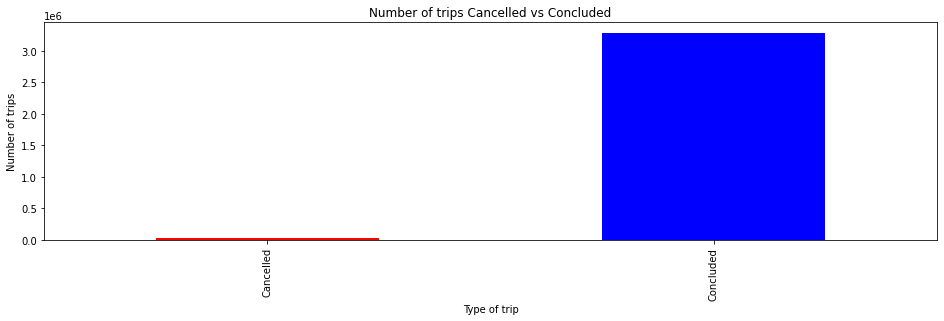

In [11]:
print(trip_distance_max_2_df.groupby(trip_distance_max_2_df.map(lambda x: 'Cancelled' if x==0 else 'Concluded'))
                          .count());
(trip_distance_max_2_df.groupby(trip_distance_max_2_df.map(lambda x: 'Cancelled' if x==0 else 'Concluded'))
                       .count()
                       .plot(kind='bar',color=['red', 'blue'], figsize= (16,4)))

plt.title('Number of trips Cancelled vs Concluded');
plt.xlabel('Type of trip');
plt.ylabel('Number of trips');
plt.show()


In [12]:
trip_distance_max_2_concluded_df = trip_distance_max_2_df[trip_distance_max_2_df!=0]

We will plot te values now to see the distance frequecy that appears inside or data

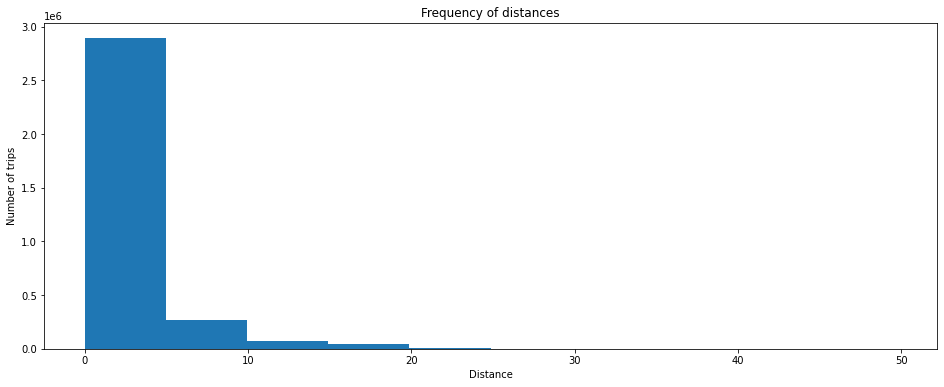

In [13]:
trip_distance_max_2_concluded_df.plot(kind='hist', figsize= (16,6))
plt.title('Frequency of distances');
plt.xlabel('Distance');
plt.ylabel('Number of trips');
plt.show()

It is clear for us that most trips has the distance of 5, but there are uncommons distances which will change the average value 

In [14]:
print(f"Average distance with outliers: {trip_distance_max_2_concluded_df.mean()}")

Average distance with outliers: 2.6880171298980713


Now we will remote the must unncommon values to create a more consistent average distance

In [15]:
Q1 = trip_distance_max_2_concluded_df.quantile(0.25)
Q3 = trip_distance_max_2_concluded_df.quantile(0.75)
IQR = Q3 - Q1

no_outlier = trip_distance_max_2_concluded_df.map(lambda x: x > (Q1 - 1.5 * IQR) and x < (Q3 + 1.5 * IQR))
trip_distance_max_2_concluded_no_outlier_df = trip_distance_max_2_concluded_df[no_outlier]
perc_concluded = trip_distance_max_2_concluded_no_outlier_df.shape[0] / trip_distance_max_2_concluded_df.shape[0] * 100
print(f"Percentage of data with no outliers: {perc_concluded}%")

Percentage of data with no outliers: 90.90230073122696%


Since we have enough data to use we can keep going our analysis

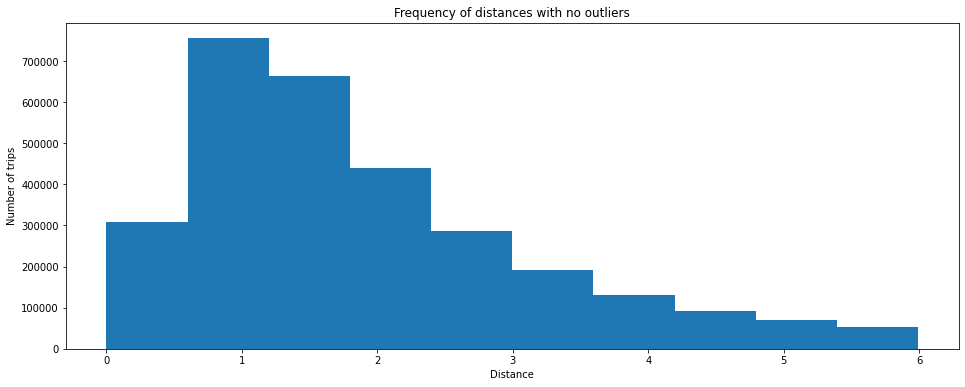

In [16]:
trip_distance_max_2_concluded_no_outlier_df.plot(kind='hist', title='Frequency of distances with no outliers', figsize= (16,6))
plt.xlabel('Distance');
plt.ylabel('Number of trips');
plt.show()

Our graphic now has a structure  much more homogeneous and we can check our average distance

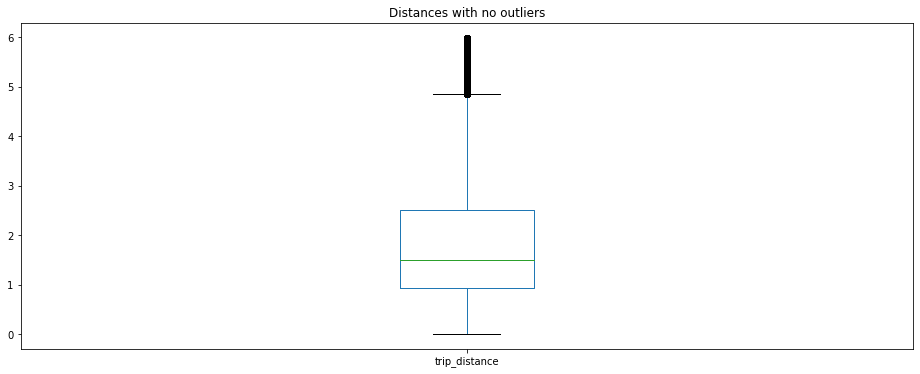

In [17]:
trip_distance_max_2_concluded_no_outlier_df.plot(kind='box', title='Distances with no outliers', figsize= (16,6))

In [18]:
print(f"Average distance without outliers: {trip_distance_max_2_concluded_no_outlier_df.mean()}")

Average distance without outliers: 1.8825347423553467


## 2. Which are the 3 biggest vendors based on the total amount of money raised:

In [19]:
vendors_and_money_df =  nyc_taxi_trips_df[['vendor_id','total_amount']]

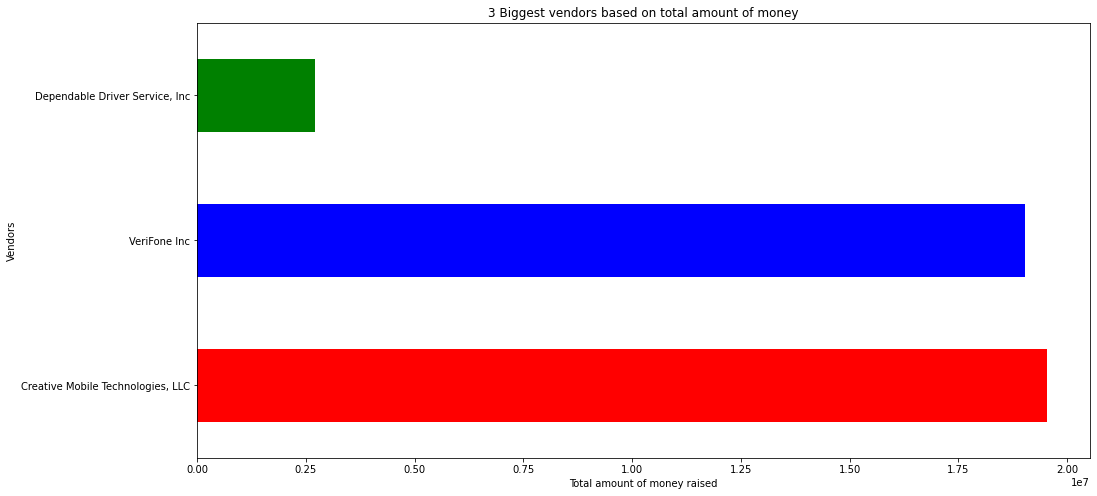

In [20]:
biggest_vendors_df = (vendors_and_money_df.groupby('vendor_id')
                                          .sum()
                                          .join(payment_df.set_index('vendor_id'), how='left')
                                          .loc[:,['name','total_amount']]
                                          .sort_values(by='total_amount', ascending=False)[:3])

biggest_vendors_df.plot(x = 'name', kind='barh', figsize= (16,8), color=('red','blue', 'green'), legend=False)
plt.title('3 Biggest vendors based on total amount of money')
plt.ylabel('Vendors');
plt.xlabel('Total amount of money raised');
plt.show()

In [21]:
biggest_vendors_df

,name,total_amount
vendor_id,,
CMT,"Creative Mobile Technologies, LLC",19549084.00
VTS,VeriFone Inc,19043434.00
DDS,"Dependable Driver Service, Inc",2714901.75


We can see that the biggest three vendor are Creative Mobile Technologie, VeriFone and Dependable Driver Service

## 3. Make a histogram of the monthly distribution over 4 years of rides paid with cash:

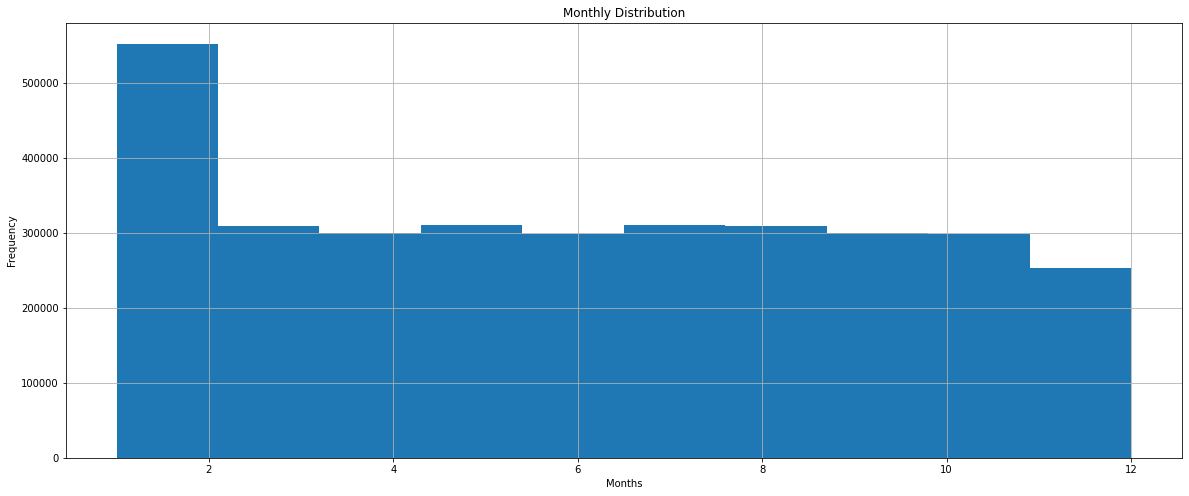

In [22]:
only_cash = nyc_taxi_trips_df.payment_type.str.lower() == 'cash'
nyc_taxi_trips_df[only_cash].pickup_datetime.dt.month.hist(figsize= (20,8))

plt.title('Monthly Distribution')
plt.xlabel('Months');
plt.ylabel('Frequency');
plt.show()

We can notice that there is a large number of trips during January and less in December. A theory is, since people visit their family during the holydays at the end of the year, there is a decrease in the population, which reduces the number of trips. Oppositely to it, in January, everyone is back and it is still Winter, which makes people desire to arrive at their destination faster. Besides it, according to [Tourist companies](https://www.nytimes.com/2019/01/16/nyregion/nyc-tourism-record.html), January is the best month to vist NY, increasing the number of tourists and the number of trips.

## 4. Make a time series chart computing the number of tips each day for the last 3 months of 2012:

In [23]:
from datetime import date
last_day=nyc_taxi_trips_df[nyc_taxi_trips_df.pickup_datetime.dt.year == 2012].pickup_datetime.dt.date.max()
first_day = date(last_day.year, last_day.month-2, last_day.day)

last_3_months_2012 = (nyc_taxi_trips_df.pickup_datetime.dt.date > first_day) & (nyc_taxi_trips_df.tip_amount > 0) 
trip_with_tips_3_mon_2012_df = nyc_taxi_trips_df[last_3_months_2012]

tip_per_day_df = trip_with_tips_3_mon_2012_df.tip_amount.groupby(nyc_taxi_trips_df[last_3_months_2012].pickup_datetime.dt.date).count()

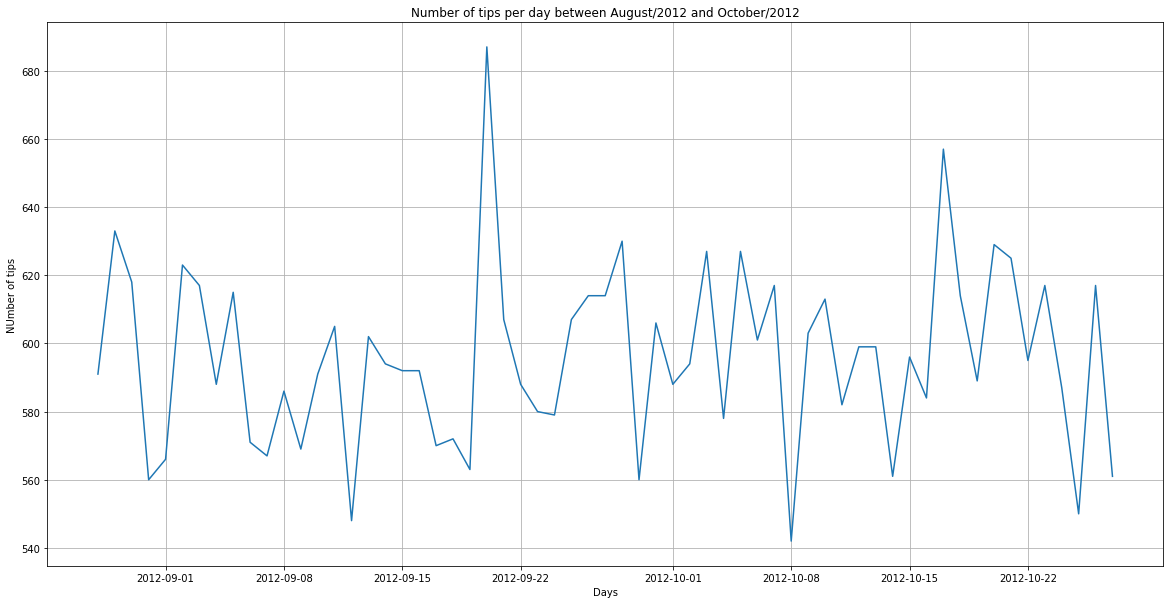

In [24]:
tip_per_day_df.plot(kind='line', figsize= (20,10), grid=True)

plt.title('Number of tips per day between August/2012 and October/2012')
plt.xlabel('Days');
plt.ylabel('NUmber of tips');
plt.show()

## **Bonus items**

## What is the average trip time on Saturdays and Sundays

In [25]:
trip_on_wkends_df = nyc_taxi_trips_df.loc[nyc_taxi_trips_df.pickup_datetime.dt.dayofweek >=5, ['pickup_datetime', 'dropoff_datetime']]
trip_on_wkends_df['trip_time'] = (trip_on_wkends_df.dropoff_datetime - trip_on_wkends_df.pickup_datetime).astype('int')
trip_on_wkends_df['day_of_week'] = trip_on_wkends_df.pickup_datetime.dt.dayofweek.map(lambda x: 'Saturday' if x==5 else 'Sunday')

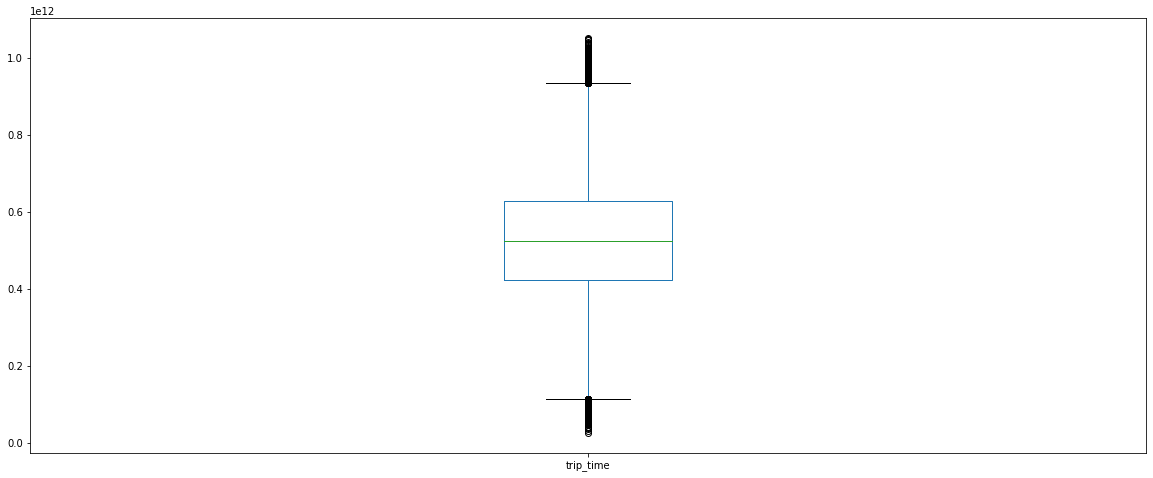

In [26]:
trip_on_wkends_df.trip_time.plot(kind='box', figsize=(20,8))

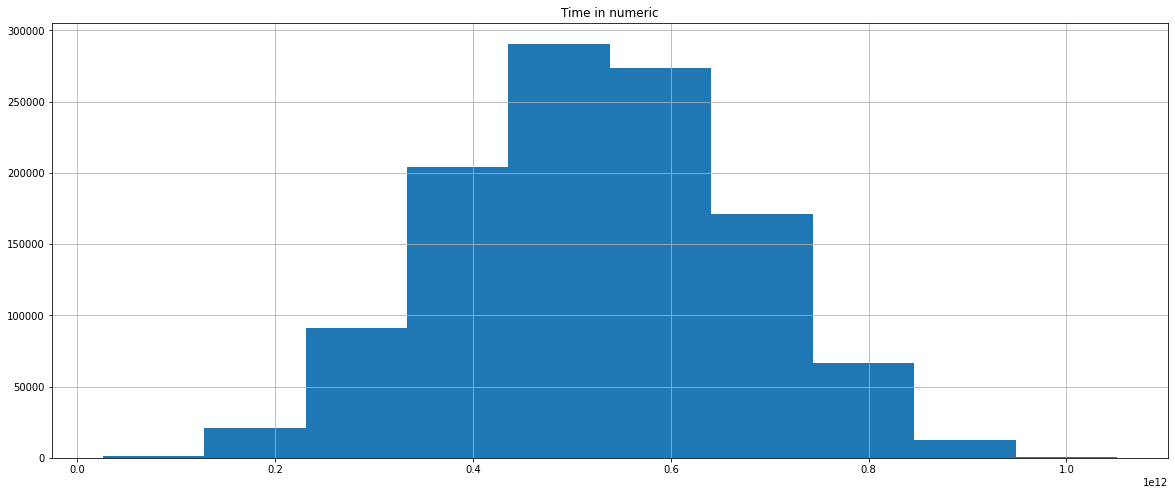

In [27]:
trip_on_wkends_df.trip_time.hist(figsize=(20,8))
plt.title('Time in numeric')
plt.show()

Looking on the value we can see that there is a normal distribuction and we do not need to remove the outliers

In [28]:
trip_on_wkends_df.groupby('day_of_week').mean().astype('timedelta64[ns]')

,trip_time
day_of_week,
Saturday,00:08:44.939775
Sunday,00:08:44.641298


## Analyse the data to find and prove seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(nyc_taxi_trips_df.groupby('pickup_day').total_amount.sum())

To solve this problem I would group the values by week and use seasonal_decompose to decomp the time series in its components. With this information I would be capable of proof graphically seasonality